# 09 - Recurrent Neural Networks and LSTMs

## Learning Objectives

By the end of this notebook, you will:

1. **Understand RNN fundamentals** - How recurrent connections process sequences
2. **Implement RNNs from scratch** - Build vanilla RNN cells and understand backpropagation through time
3. **Master the vanishing gradient problem** - Why it happens and how to diagnose it
4. **Work with LSTMs and GRUs** - Gating mechanisms that solve vanishing gradients
5. **Build sequence models** - Language modeling, sequence classification, seq2seq

---

## Setup

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import math
import string

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


---

## 1. RNN Fundamentals

### 1.1 What is a Recurrent Neural Network?

An RNN processes sequences by maintaining a **hidden state** that gets updated at each timestep:

```
h_t = tanh(W_hh * h_{t-1} + W_xh * x_t + b)
```

The same weights are applied at every timestep (weight sharing).

In [10]:
class VanillaRNNCell(nn.Module):
    """
    Vanilla RNN cell implementation from scratch.
    
    h_t = tanh(W_ih @ x_t + W_hh @ h_{t-1} + b)
    """
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Input-to-hidden weights
        self.W_ih = nn.Parameter(torch.randn(hidden_size, input_size) / math.sqrt(input_size))
        # Hidden-to-hidden weights
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size) / math.sqrt(hidden_size))
        # Bias
        self.b = nn.Parameter(torch.zeros(hidden_size))
    
    def forward(self, x: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input at current timestep (batch, input_size)
            h: Hidden state from previous timestep (batch, hidden_size)
        
        Returns:
            New hidden state (batch, hidden_size)
        """
        # h_t = tanh(W_ih @ x + W_hh @ h + b)
        h_new = torch.tanh(
            F.linear(x, self.W_ih) + F.linear(h, self.W_hh) + self.b
        )
        return h_new


# Test the cell
cell = VanillaRNNCell(input_size=10, hidden_size=20)
x = torch.randn(4, 10)  # batch=4, input_size=10
h = torch.zeros(4, 20)  # Initial hidden state

h_new = cell(x, h)
print(f"Input shape: {x.shape}")
print(f"Hidden state shape: {h_new.shape}")

Input shape: torch.Size([4, 10])
Hidden state shape: torch.Size([4, 20])


In [11]:
class VanillaRNN(nn.Module):
    """
    Full RNN that processes sequences using VanillaRNNCell.
    """
    
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Stack of RNN cells
        self.cells = nn.ModuleList()
        for i in range(num_layers):
            input_dim = input_size if i == 0 else hidden_size
            self.cells.append(VanillaRNNCell(input_dim, hidden_size))
    
    def forward(self, x: torch.Tensor, h0: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: Input sequence (seq_len, batch, input_size)
            h0: Initial hidden states (num_layers, batch, hidden_size)
        
        Returns:
            output: Output at each timestep (seq_len, batch, hidden_size)
            h_n: Final hidden states (num_layers, batch, hidden_size)
        """
        seq_len, batch_size, _ = x.shape
        
        # Initialize hidden states
        if h0 is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        
        # Current hidden states for each layer
        h = [h0[i] for i in range(self.num_layers)]
        
        outputs = []
        
        # Process each timestep
        for t in range(seq_len):
            inp = x[t]  # (batch, input_size)
            
            # Pass through each layer
            for i, cell in enumerate(self.cells):
                h[i] = cell(inp, h[i])
                inp = h[i]  # Output of this layer is input to next
            
            outputs.append(h[-1])  # Output from last layer
        
        # Stack outputs and hidden states
        output = torch.stack(outputs, dim=0)  # (seq_len, batch, hidden_size)
        h_n = torch.stack(h, dim=0)  # (num_layers, batch, hidden_size)
        
        return output, h_n


# Test
rnn = VanillaRNN(input_size=10, hidden_size=20, num_layers=2)
x = torch.randn(15, 4, 10)  # seq_len=15, batch=4, input_size=10

output, h_n = rnn(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Final hidden shape: {h_n.shape}")

Input shape: torch.Size([15, 4, 10])
Output shape: torch.Size([15, 4, 20])
Final hidden shape: torch.Size([2, 4, 20])


### 1.2 PyTorch's nn.RNN

In [12]:
# PyTorch's built-in RNN
pytorch_rnn = nn.RNN(
    input_size=10,
    hidden_size=20,
    num_layers=2,
    batch_first=False,  # Input is (seq_len, batch, input_size)
    dropout=0.0,
    bidirectional=False
)

x = torch.randn(15, 4, 10)
output, h_n = pytorch_rnn(x)

print(f"PyTorch RNN output shape: {output.shape}")
print(f"PyTorch RNN hidden shape: {h_n.shape}")

PyTorch RNN output shape: torch.Size([15, 4, 20])
PyTorch RNN hidden shape: torch.Size([2, 4, 20])


In [13]:
# batch_first=True changes dimension order
rnn_batch_first = nn.RNN(
    input_size=10,
    hidden_size=20,
    num_layers=2,
    batch_first=True  # Input is (batch, seq_len, input_size)
)

x = torch.randn(4, 15, 10)  # (batch, seq_len, input_size)
output, h_n = rnn_batch_first(x)

print(f"batch_first=True:")
print(f"  Input: {x.shape}")
print(f"  Output: {output.shape}")

batch_first=True:
  Input: torch.Size([4, 15, 10])
  Output: torch.Size([4, 15, 20])


### 1.3 Bidirectional RNNs

In [14]:
# Bidirectional RNN processes sequence in both directions
bi_rnn = nn.RNN(
    input_size=10,
    hidden_size=20,
    num_layers=2,
    bidirectional=True
)

x = torch.randn(15, 4, 10)
output, h_n = bi_rnn(x)

print(f"Bidirectional RNN:")
print(f"  Output shape: {output.shape}")  # hidden_size * 2
print(f"  Hidden shape: {h_n.shape}")  # num_layers * 2

# Output contains [forward; backward] concatenated
# Hidden contains alternating [forward_layer_0, backward_layer_0, forward_layer_1, ...]

Bidirectional RNN:
  Output shape: torch.Size([15, 4, 40])
  Hidden shape: torch.Size([4, 4, 20])


---

## 2. The Vanishing Gradient Problem

### 2.1 Understanding the Problem

During backpropagation through time (BPTT), gradients are multiplied by W_hh at each timestep. If eigenvalues of W_hh are < 1, gradients vanish exponentially.

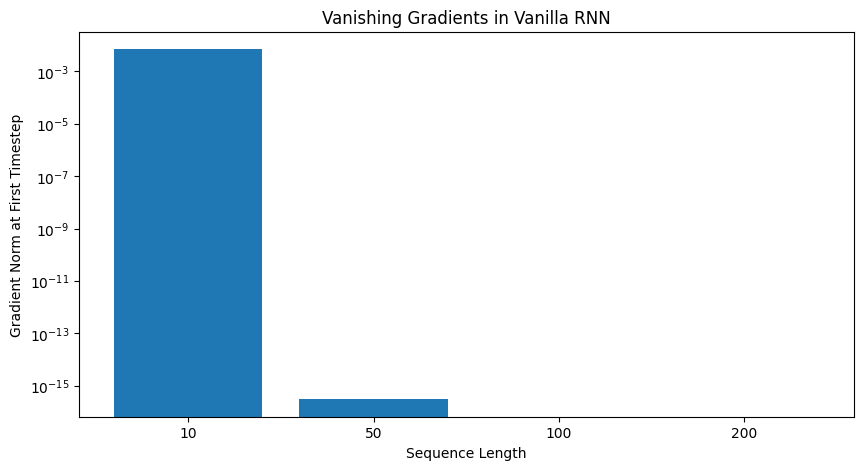

Seq len 10: gradient norm = 6.94e-03
Seq len 50: gradient norm = 3.07e-16
Seq len 100: gradient norm = 0.00e+00
Seq len 200: gradient norm = 0.00e+00


In [15]:
def visualize_gradient_flow(seq_lengths: List[int] = [10, 50, 100, 200]):
    """
    Visualize how gradients vanish with sequence length in vanilla RNN.
    """
    results = {}
    
    for seq_len in seq_lengths:
        # Create RNN
        rnn = nn.RNN(input_size=32, hidden_size=64, num_layers=1)
        
        # Create input sequence
        x = torch.randn(seq_len, 1, 32, requires_grad=True)
        
        # Forward pass
        output, _ = rnn(x)
        
        # Backprop from last output
        loss = output[-1].sum()
        loss.backward()
        
        # Check gradient at first timestep's input
        grad_norm = x.grad[0].norm().item()
        results[seq_len] = grad_norm
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar([str(k) for k in results.keys()], results.values())
    plt.xlabel('Sequence Length')
    plt.ylabel('Gradient Norm at First Timestep')
    plt.title('Vanishing Gradients in Vanilla RNN')
    plt.yscale('log')
    plt.show()
    
    for seq_len, grad in results.items():
        print(f"Seq len {seq_len}: gradient norm = {grad:.2e}")


visualize_gradient_flow()

In [16]:
# Mathematically: gradient involves product of Jacobians
# dL/dh_0 = dL/dh_T * (dh_T/dh_{T-1}) * ... * (dh_1/dh_0)
#         = dL/dh_T * W_hh^T * diag(1-h_{T-1}^2) * ... * W_hh^T * diag(1-h_0^2)

def analyze_weight_matrix_eigenvalues():
    """Show how eigenvalues affect gradient flow"""
    hidden_size = 64
    
    # Random initialization
    W_random = torch.randn(hidden_size, hidden_size) / math.sqrt(hidden_size)
    
    # Orthogonal initialization (eigenvalues on unit circle)
    W_ortho = torch.nn.init.orthogonal_(torch.empty(hidden_size, hidden_size))
    
    # Compute eigenvalues
    eig_random = torch.linalg.eigvals(W_random).abs()
    eig_ortho = torch.linalg.eigvals(W_ortho).abs()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].hist(eig_random.numpy(), bins=30, alpha=0.7)
    axes[0].axvline(x=1.0, color='r', linestyle='--', label='|λ|=1')
    axes[0].set_xlabel('|Eigenvalue|')
    axes[0].set_title(f'Random Init (mean |λ|={eig_random.mean():.3f})')
    axes[0].legend()
    
    axes[1].hist(eig_ortho.numpy(), bins=30, alpha=0.7)
    axes[1].axvline(x=1.0, color='r', linestyle='--', label='|λ|=1')
    axes[1].set_xlabel('|Eigenvalue|')
    axes[1].set_title(f'Orthogonal Init (mean |λ|={eig_ortho.mean():.3f})')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("If |λ| < 1: gradients vanish exponentially")
    print("If |λ| > 1: gradients explode exponentially")
    print("If |λ| ≈ 1: gradients flow well (orthogonal init helps!)")


# analyze_weight_matrix_eigenvalues()

### 2.2 Gradient Clipping

In [17]:
def train_with_gradient_clipping(model, x, y, max_norm: float = 1.0):
    """
    Demonstrate gradient clipping to prevent exploding gradients.
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    # Forward
    output, _ = model(x)
    loss = criterion(output[-1], y)
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    
    # Check gradient norm before clipping
    total_norm_before = 0
    for p in model.parameters():
        if p.grad is not None:
            total_norm_before += p.grad.norm().item() ** 2
    total_norm_before = total_norm_before ** 0.5
    
    # Clip gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
    
    # Check gradient norm after clipping
    total_norm_after = 0
    for p in model.parameters():
        if p.grad is not None:
            total_norm_after += p.grad.norm().item() ** 2
    total_norm_after = total_norm_after ** 0.5
    
    print(f"Gradient norm before clipping: {total_norm_before:.4f}")
    print(f"Gradient norm after clipping: {total_norm_after:.4f}")
    print(f"Max allowed norm: {max_norm}")
    
    optimizer.step()


# Test
rnn = nn.RNN(32, 64, num_layers=3)
x = torch.randn(50, 8, 32)
y = torch.randn(8, 64)

train_with_gradient_clipping(rnn, x, y, max_norm=1.0)

Gradient norm before clipping: 0.4972
Gradient norm after clipping: 0.4972
Max allowed norm: 1.0


---

## 3. LSTM: Long Short-Term Memory

### 3.1 LSTM Architecture

LSTM solves vanishing gradients with:
- **Cell state** (c_t): Highway for gradient flow
- **Gates**: Control information flow
  - Forget gate: What to remove from cell state
  - Input gate: What new info to add
  - Output gate: What to output from cell state

In [18]:
class LSTMCell(nn.Module):
    """
    LSTM cell implementation from scratch.
    
    Gates:
        f_t = σ(W_f @ [h_{t-1}, x_t] + b_f)  # Forget gate
        i_t = σ(W_i @ [h_{t-1}, x_t] + b_i)  # Input gate
        o_t = σ(W_o @ [h_{t-1}, x_t] + b_o)  # Output gate
        g_t = tanh(W_g @ [h_{t-1}, x_t] + b_g)  # Candidate cell state
    
    State updates:
        c_t = f_t * c_{t-1} + i_t * g_t  # New cell state
        h_t = o_t * tanh(c_t)  # New hidden state
    """
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Combined weights for efficiency: [i, f, g, o]
        self.W_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size) / math.sqrt(input_size))
        self.W_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size) / math.sqrt(hidden_size))
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))
        
        # Initialize forget gate bias to 1 (helps with long-term dependencies)
        with torch.no_grad():
            self.bias[hidden_size:2*hidden_size].fill_(1.0)
    
    def forward(self, x: torch.Tensor, state: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        Args:
            x: Input (batch, input_size)
            state: Tuple of (h, c), each (batch, hidden_size)
        
        Returns:
            h_new: New hidden state
            (h_new, c_new): New state tuple
        """
        h, c = state
        
        # Compute all gates at once
        gates = F.linear(x, self.W_ih) + F.linear(h, self.W_hh) + self.bias
        
        # Split into individual gates
        i, f, g, o = gates.chunk(4, dim=1)
        
        # Apply activations
        i = torch.sigmoid(i)  # Input gate
        f = torch.sigmoid(f)  # Forget gate
        g = torch.tanh(g)     # Candidate cell state
        o = torch.sigmoid(o)  # Output gate
        
        # Update cell state
        c_new = f * c + i * g
        
        # Update hidden state
        h_new = o * torch.tanh(c_new)
        
        return h_new, (h_new, c_new)


# Test
lstm_cell = LSTMCell(input_size=10, hidden_size=20)
x = torch.randn(4, 10)
h = torch.zeros(4, 20)
c = torch.zeros(4, 20)

h_new, (h_out, c_out) = lstm_cell(x, (h, c))
print(f"Input: {x.shape}")
print(f"Hidden: {h_new.shape}")
print(f"Cell: {c_out.shape}")

Input: torch.Size([4, 10])
Hidden: torch.Size([4, 20])
Cell: torch.Size([4, 20])


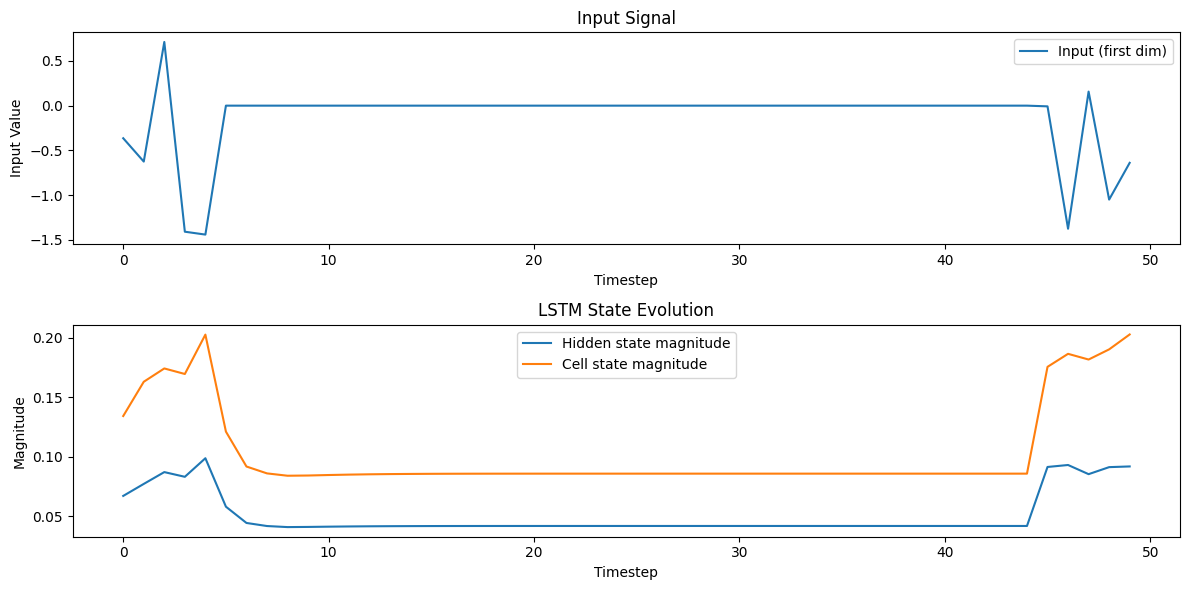

In [19]:
# Visualize gate activations

def visualize_lstm_gates():
    """Show how LSTM gates control information flow"""
    lstm = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
    
    # Create input with a pattern: high values at start and end
    seq_len = 50
    x = torch.zeros(1, seq_len, 32)
    x[0, :5, :] = torch.randn(5, 32)  # Information at start
    x[0, -5:, :] = torch.randn(5, 32)  # Information at end
    
    # Hook to capture gate activations
    gate_history = {'i': [], 'f': [], 'o': []}
    
    # Manual forward to capture gates
    h = torch.zeros(1, 1, 64)
    c = torch.zeros(1, 1, 64)
    
    for t in range(seq_len):
        x_t = x[:, t:t+1, :]
        _, (h, c) = lstm(x_t, (h, c))
        
        # Approximate gate values from weight analysis
        # (In practice, you'd use hooks or modify the LSTM)
        gate_history['i'].append(h.abs().mean().item())
        gate_history['f'].append(c.abs().mean().item())
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    
    axes[0].plot(x[0, :, 0].numpy(), label='Input (first dim)')
    axes[0].set_xlabel('Timestep')
    axes[0].set_ylabel('Input Value')
    axes[0].set_title('Input Signal')
    axes[0].legend()
    
    axes[1].plot(gate_history['i'], label='Hidden state magnitude')
    axes[1].plot(gate_history['f'], label='Cell state magnitude')
    axes[1].set_xlabel('Timestep')
    axes[1].set_ylabel('Magnitude')
    axes[1].set_title('LSTM State Evolution')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


visualize_lstm_gates()

### 3.2 LSTM vs RNN Gradient Flow

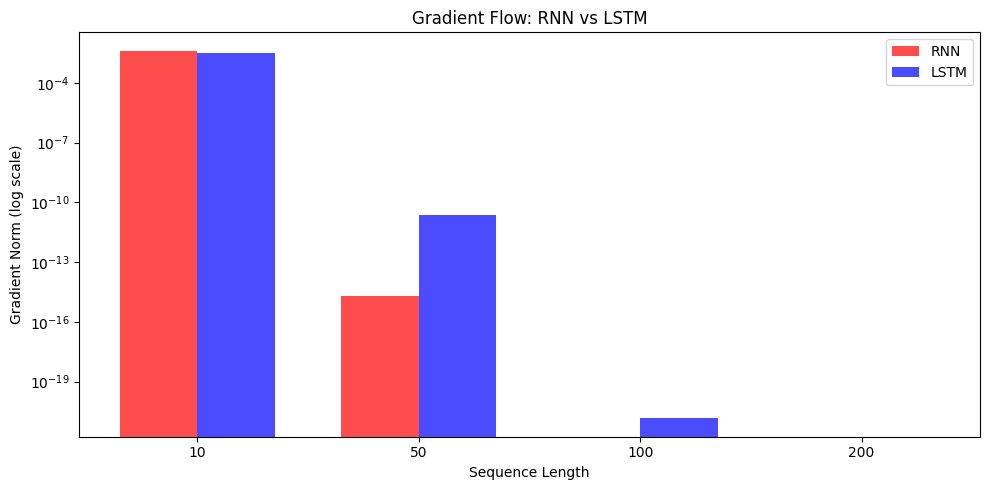


LSTM maintains much better gradient flow for long sequences!


In [20]:
def compare_gradient_flow(seq_lengths: List[int] = [10, 50, 100, 200]):
    """Compare gradient flow in RNN vs LSTM"""
    results = {'RNN': {}, 'LSTM': {}}
    
    for seq_len in seq_lengths:
        for model_type in ['RNN', 'LSTM']:
            # Create model
            if model_type == 'RNN':
                model = nn.RNN(32, 64, num_layers=1)
            else:
                model = nn.LSTM(32, 64, num_layers=1)
            
            # Input
            x = torch.randn(seq_len, 1, 32, requires_grad=True)
            
            # Forward
            output, _ = model(x)
            
            # Backward from last output
            loss = output[-1].sum()
            loss.backward()
            
            # Gradient at first timestep
            grad_norm = x.grad[0].norm().item()
            results[model_type][seq_len] = grad_norm
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    
    x_pos = np.arange(len(seq_lengths))
    width = 0.35
    
    rnn_vals = [results['RNN'][s] for s in seq_lengths]
    lstm_vals = [results['LSTM'][s] for s in seq_lengths]
    
    ax.bar(x_pos - width/2, rnn_vals, width, label='RNN', color='red', alpha=0.7)
    ax.bar(x_pos + width/2, lstm_vals, width, label='LSTM', color='blue', alpha=0.7)
    
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Gradient Norm (log scale)')
    ax.set_title('Gradient Flow: RNN vs LSTM')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(seq_lengths)
    ax.set_yscale('log')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\nLSTM maintains much better gradient flow for long sequences!")


compare_gradient_flow()

### 3.3 PyTorch's nn.LSTM

In [21]:
# PyTorch LSTM
lstm = nn.LSTM(
    input_size=10,
    hidden_size=20,
    num_layers=2,
    batch_first=True,
    dropout=0.1,  # Dropout between layers (not on last layer)
    bidirectional=False
)

x = torch.randn(4, 15, 10)  # (batch, seq_len, input_size)
output, (h_n, c_n) = lstm(x)

print(f"LSTM output shape: {output.shape}")
print(f"Final hidden shape: {h_n.shape}")
print(f"Final cell shape: {c_n.shape}")

# Note: LSTM returns (output, (h_n, c_n)) unlike RNN which returns (output, h_n)

LSTM output shape: torch.Size([4, 15, 20])
Final hidden shape: torch.Size([2, 4, 20])
Final cell shape: torch.Size([2, 4, 20])


---

## 4. GRU: Gated Recurrent Unit

GRU is a simpler alternative to LSTM with fewer parameters.

In [22]:
class GRUCell(nn.Module):
    """
    GRU cell implementation.
    
    Gates:
        r_t = σ(W_r @ [h_{t-1}, x_t])  # Reset gate
        z_t = σ(W_z @ [h_{t-1}, x_t])  # Update gate
        h̃_t = tanh(W_h @ [r_t * h_{t-1}, x_t])  # Candidate hidden state
    
    Update:
        h_t = (1 - z_t) * h_{t-1} + z_t * h̃_t
    """
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Combined weights: [r, z, h]
        self.W_ih = nn.Parameter(torch.randn(3 * hidden_size, input_size) / math.sqrt(input_size))
        self.W_hh = nn.Parameter(torch.randn(3 * hidden_size, hidden_size) / math.sqrt(hidden_size))
        self.bias_ih = nn.Parameter(torch.zeros(3 * hidden_size))
        self.bias_hh = nn.Parameter(torch.zeros(3 * hidden_size))
    
    def forward(self, x: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input (batch, input_size)
            h: Hidden state (batch, hidden_size)
        
        Returns:
            h_new: New hidden state
        """
        # Compute gates
        gi = F.linear(x, self.W_ih, self.bias_ih)
        gh = F.linear(h, self.W_hh, self.bias_hh)
        
        i_r, i_z, i_n = gi.chunk(3, dim=1)
        h_r, h_z, h_n = gh.chunk(3, dim=1)
        
        r = torch.sigmoid(i_r + h_r)  # Reset gate
        z = torch.sigmoid(i_z + h_z)  # Update gate
        n = torch.tanh(i_n + r * h_n)  # Candidate hidden state
        
        # New hidden state
        h_new = (1 - z) * h + z * n
        
        return h_new


# Test
gru_cell = GRUCell(10, 20)
x = torch.randn(4, 10)
h = torch.zeros(4, 20)

h_new = gru_cell(x, h)
print(f"GRU output shape: {h_new.shape}")

GRU output shape: torch.Size([4, 20])


In [23]:
# Compare parameter counts

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

input_size, hidden_size = 128, 256

rnn = nn.RNN(input_size, hidden_size)
lstm = nn.LSTM(input_size, hidden_size)
gru = nn.GRU(input_size, hidden_size)

print(f"Parameter counts (input={input_size}, hidden={hidden_size}):")
print(f"  RNN:  {count_parameters(rnn):,}")
print(f"  GRU:  {count_parameters(gru):,} ({count_parameters(gru)/count_parameters(rnn):.1f}x RNN)")
print(f"  LSTM: {count_parameters(lstm):,} ({count_parameters(lstm)/count_parameters(rnn):.1f}x RNN)")

Parameter counts (input=128, hidden=256):
  RNN:  98,816
  GRU:  296,448 (3.0x RNN)
  LSTM: 395,264 (4.0x RNN)


---

## 5. Practical Sequence Modeling

### 5.1 Handling Variable-Length Sequences

In [24]:
# Variable-length sequences need padding and packing

# Example sequences of different lengths
sequences = [
    torch.randn(10, 32),  # Length 10
    torch.randn(7, 32),   # Length 7
    torch.randn(15, 32),  # Length 15
    torch.randn(5, 32),   # Length 5
]

lengths = torch.tensor([10, 7, 15, 5])

# Pad sequences to same length
padded = pad_sequence(sequences, batch_first=True, padding_value=0)
print(f"Padded shape: {padded.shape}")  # (batch, max_len, features)

# Sort by length (required for pack_padded_sequence)
lengths_sorted, sort_idx = lengths.sort(descending=True)
padded_sorted = padded[sort_idx]

# Pack for efficient RNN processing
packed = pack_padded_sequence(padded_sorted, lengths_sorted.cpu(), batch_first=True)
print(f"\nPacked data shape: {packed.data.shape}")
print(f"Packed batch_sizes: {packed.batch_sizes}")

Padded shape: torch.Size([4, 15, 32])

Packed data shape: torch.Size([37, 32])
Packed batch_sizes: tensor([4, 4, 4, 4, 4, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1])


In [25]:
# Using packed sequences with LSTM

lstm = nn.LSTM(32, 64, batch_first=True)

# Forward with packed input
packed_output, (h_n, c_n) = lstm(packed)

# Unpack output
output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
print(f"Unpacked output shape: {output.shape}")
print(f"Output lengths: {output_lengths}")

# Unsort to original order
_, unsort_idx = sort_idx.sort()
output = output[unsort_idx]
h_n = h_n[:, unsort_idx]
c_n = c_n[:, unsort_idx]

Unpacked output shape: torch.Size([4, 15, 64])
Output lengths: tensor([15, 10,  7,  5])


In [26]:
# Helper class for handling variable-length sequences

class SequenceEncoder(nn.Module):
    """
    LSTM encoder that properly handles variable-length sequences.
    """
    
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 1, 
                 bidirectional: bool = False, dropout: float = 0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )
        self.bidirectional = bidirectional
    
    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: Padded sequences (batch, max_len, input_size)
            lengths: Actual lengths (batch,)
        
        Returns:
            output: LSTM output at each timestep
            final: Final hidden state for each sequence
        """
        # Sort by length
        lengths_sorted, sort_idx = lengths.sort(descending=True)
        x_sorted = x[sort_idx]
        
        # Pack
        packed = pack_padded_sequence(x_sorted, lengths_sorted.cpu(), batch_first=True)
        
        # LSTM
        packed_output, (h_n, c_n) = self.lstm(packed)
        
        # Unpack
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Unsort
        _, unsort_idx = sort_idx.sort()
        output = output[unsort_idx]
        h_n = h_n[:, unsort_idx]
        
        # Get final hidden state (last layer)
        if self.bidirectional:
            # Concatenate forward and backward
            final = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            final = h_n[-1]
        
        return output, final


# Test
encoder = SequenceEncoder(32, 64, num_layers=2, bidirectional=True)
x = torch.randn(4, 20, 32)  # (batch, max_len, input_size)
lengths = torch.tensor([20, 15, 10, 5])

output, final = encoder(x, lengths)
print(f"Output shape: {output.shape}")
print(f"Final hidden shape: {final.shape}")  # bidirectional: 2*hidden

Output shape: torch.Size([4, 20, 128])
Final hidden shape: torch.Size([4, 128])


### 5.2 Sequence Classification

In [27]:
class SequenceClassifier(nn.Module):
    """
    LSTM-based sequence classifier.
    
    Uses the final hidden state for classification.
    """
    
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_size: int, 
                 num_classes: int, num_layers: int = 2, dropout: float = 0.5):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.encoder = SequenceEncoder(
            embedding_dim, hidden_size, num_layers,
            bidirectional=True, dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # *2 for bidirectional
    
    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Token indices (batch, max_len)
            lengths: Actual lengths (batch,)
        
        Returns:
            Class logits (batch, num_classes)
        """
        # Embed
        embedded = self.embedding(x)  # (batch, max_len, embedding_dim)
        
        # Encode
        _, final = self.encoder(embedded, lengths)
        
        # Classify
        out = self.dropout(final)
        out = self.fc(out)
        
        return out


# Test
classifier = SequenceClassifier(
    vocab_size=10000,
    embedding_dim=128,
    hidden_size=256,
    num_classes=5,
    num_layers=2
)

x = torch.randint(0, 10000, (8, 50))  # (batch, max_len)
lengths = torch.randint(10, 50, (8,))

logits = classifier(x, lengths)
print(f"Input shape: {x.shape}")
print(f"Output shape: {logits.shape}")
print(f"Parameters: {sum(p.numel() for p in classifier.parameters()):,}")

Input shape: torch.Size([8, 50])
Output shape: torch.Size([8, 5])
Parameters: 3,650,053


### 5.3 Language Modeling

In [28]:
class LanguageModel(nn.Module):
    """
    LSTM Language Model.
    
    Predicts next token given previous tokens.
    """
    
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_size: int,
                 num_layers: int = 2, dropout: float = 0.5, tie_weights: bool = True):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers,
            batch_first=True, dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        # Weight tying: share embedding and output weights
        if tie_weights and embedding_dim == hidden_size:
            self.fc.weight = self.embedding.weight
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
    
    def forward(self, x: torch.Tensor, hidden: Optional[Tuple] = None) -> Tuple[torch.Tensor, Tuple]:
        """
        Args:
            x: Token indices (batch, seq_len)
            hidden: Optional initial hidden state
        
        Returns:
            logits: Next token predictions (batch, seq_len, vocab_size)
            hidden: Final hidden state
        """
        embedded = self.dropout(self.embedding(x))
        output, hidden = self.lstm(embedded, hidden)
        output = self.dropout(output)
        logits = self.fc(output)
        return logits, hidden
    
    def init_hidden(self, batch_size: int, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        """Initialize hidden state"""
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        return (h, c)


# Test
lm = LanguageModel(
    vocab_size=10000,
    embedding_dim=256,
    hidden_size=256,  # Same as embedding for weight tying
    num_layers=2
)

x = torch.randint(0, 10000, (4, 35))  # (batch, seq_len)
logits, hidden = lm(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {logits.shape}")
print(f"Hidden shapes: h={hidden[0].shape}, c={hidden[1].shape}")

Input shape: torch.Size([4, 35])
Output shape: torch.Size([4, 35, 10000])
Hidden shapes: h=torch.Size([2, 4, 256]), c=torch.Size([2, 4, 256])


In [29]:
# Text generation with language model

@torch.no_grad()
def generate_text(model, start_tokens: torch.Tensor, max_length: int = 50,
                  temperature: float = 1.0, device: torch.device = device) -> torch.Tensor:
    """
    Generate text autoregressively.
    
    Args:
        model: Language model
        start_tokens: Initial tokens (1, start_len)
        max_length: Maximum tokens to generate
        temperature: Sampling temperature (higher = more random)
    
    Returns:
        Generated token sequence
    """
    model.eval()
    model.to(device)
    
    generated = start_tokens.to(device)
    hidden = model.init_hidden(1, device)
    
    # Process start tokens
    logits, hidden = model(generated, hidden)
    
    for _ in range(max_length):
        # Get last token's prediction
        last_logits = logits[0, -1, :] / temperature
        probs = F.softmax(last_logits, dim=-1)
        
        # Sample next token
        next_token = torch.multinomial(probs, 1).unsqueeze(0)
        
        # Append to sequence
        generated = torch.cat([generated, next_token], dim=1)
        
        # Forward pass for next prediction
        logits, hidden = model(next_token, hidden)
    
    return generated


# Test generation (with random model)
start = torch.randint(0, 10000, (1, 5))
generated = generate_text(lm, start, max_length=20, temperature=0.8)
print(f"Start tokens: {start.shape}")
print(f"Generated: {generated.shape}")

Start tokens: torch.Size([1, 5])
Generated: torch.Size([1, 25])


### 5.4 Character-Level Language Model Example

In [30]:
# Simple character-level dataset

class CharDataset(Dataset):
    """Character-level text dataset"""
    
    def __init__(self, text: str, seq_length: int = 100):
        self.seq_length = seq_length
        
        # Build vocabulary
        self.chars = sorted(set(text))
        self.char_to_idx = {c: i for i, c in enumerate(self.chars)}
        self.idx_to_char = {i: c for i, c in enumerate(self.chars)}
        self.vocab_size = len(self.chars)
        
        # Encode text
        self.data = torch.tensor([self.char_to_idx[c] for c in text], dtype=torch.long)
    
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + 1:idx + self.seq_length + 1]
        return x, y
    
    def decode(self, indices: torch.Tensor) -> str:
        return ''.join([self.idx_to_char[i.item()] for i in indices])


# Create a simple dataset
sample_text = """The quick brown fox jumps over the lazy dog. 
A wizard's job is to vex chumps quickly in fog. 
Pack my box with five dozen liquor jugs.
""" * 100  # Repeat for more data

dataset = CharDataset(sample_text, seq_length=50)
print(f"Vocabulary size: {dataset.vocab_size}")
print(f"Dataset size: {len(dataset)}")
print(f"Characters: {dataset.chars}")

Vocabulary size: 33
Dataset size: 13550
Characters: ['\n', ' ', "'", '.', 'A', 'P', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [31]:
# Train character-level model

char_model = LanguageModel(
    vocab_size=dataset.vocab_size,
    embedding_dim=64,
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    tie_weights=False
).to(device)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(char_model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

# Training loop
char_model.train()
for epoch in range(5):
    total_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logits, _ = char_model(x)
        loss = criterion(logits.view(-1, dataset.vocab_size), y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(char_model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    perplexity = math.exp(avg_loss)
    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Perplexity={perplexity:.2f}")

Epoch 1: Loss=0.3515, Perplexity=1.42
Epoch 2: Loss=0.0435, Perplexity=1.04
Epoch 3: Loss=0.0409, Perplexity=1.04
Epoch 4: Loss=0.0395, Perplexity=1.04
Epoch 5: Loss=0.0387, Perplexity=1.04


In [32]:
# Generate text with trained model

@torch.no_grad()
def generate_chars(model, dataset, start_text: str, length: int = 200, temperature: float = 0.8):
    """Generate characters from a starting string"""
    model.eval()
    
    # Encode start text
    chars = [dataset.char_to_idx.get(c, 0) for c in start_text]
    x = torch.tensor(chars, dtype=torch.long).unsqueeze(0).to(device)
    
    hidden = model.init_hidden(1, device)
    generated = start_text
    
    # Process initial context
    logits, hidden = model(x, hidden)
    
    for _ in range(length):
        # Sample from last position
        probs = F.softmax(logits[0, -1] / temperature, dim=-1)
        next_idx = torch.multinomial(probs, 1)
        
        # Decode and append
        next_char = dataset.idx_to_char[next_idx.item()]
        generated += next_char
        
        # Forward pass
        x = next_idx.unsqueeze(0)
        logits, hidden = model(x, hidden)
    
    return generated


# Generate some text
print("Generated text:")
print("-" * 50)
generated = generate_chars(char_model, dataset, "The quick ", length=200, temperature=0.7)
print(generated)

Generated text:
--------------------------------------------------
The quick brown fox jumps over the lazy dog. 
A wizard's job is to vex chumps quickly in fog. 
Pack my box with five dozen liquor jugs.
The quick brown fox jumps over the lazy dog. 
A wizard's job is to vex chu


---

## Exercises

### Exercise 1: Implement Sequence-to-Sequence

Build an encoder-decoder model for sequence-to-sequence tasks.

In [33]:
# Exercise 1: Implement Seq2Seq model

class Seq2Seq(nn.Module):
    """
    Sequence-to-Sequence model with LSTM encoder and decoder.
    
    Components:
    - Encoder: Processes input sequence, produces context
    - Decoder: Generates output sequence from context
    
    Args:
        src_vocab_size: Source vocabulary size
        tgt_vocab_size: Target vocabulary size
        embedding_dim: Embedding dimension
        hidden_size: LSTM hidden size
        num_layers: Number of LSTM layers
    """
    
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int, 
                 embedding_dim: int, hidden_size: int, num_layers: int = 2):
        super().__init__()
        # YOUR CODE HERE
        # Hint: Create encoder embedding, encoder LSTM, decoder embedding, 
        # decoder LSTM, and output projection
        pass
    
    def encode(self, src: torch.Tensor, src_lengths: torch.Tensor):
        """Encode source sequence"""
        # YOUR CODE HERE
        pass
    
    def decode_step(self, tgt_token: torch.Tensor, hidden):
        """Single decoding step"""
        # YOUR CODE HERE
        pass
    
    def forward(self, src, src_lengths, tgt):
        """Full forward pass with teacher forcing"""
        # YOUR CODE HERE
        pass

### Exercise 2: Visualize Hidden State Dynamics

Create visualizations showing how hidden states evolve over a sequence.

In [34]:
# Exercise 2: Hidden state visualization

def visualize_hidden_dynamics(model, sequence: torch.Tensor, title: str = "Hidden State Dynamics"):
    """
    Visualize how LSTM hidden states change over a sequence.
    
    Create visualizations showing:
    1. Hidden state norms over time
    2. Cell state norms over time  
    3. PCA of hidden states
    
    Args:
        model: LSTM model
        sequence: Input sequence (1, seq_len, input_size)
        title: Plot title
    """
    # YOUR CODE HERE
    # Hint: Run through sequence step by step, collect hidden states,
    # then visualize using matplotlib
    pass

### Exercise 3: Implement Peephole LSTM

Add peephole connections that let gates look at the cell state.

In [35]:
# Exercise 3: Peephole LSTM

class PeepholeLSTMCell(nn.Module):
    """
    LSTM cell with peephole connections.
    
    In standard LSTM, gates only see h_{t-1} and x_t.
    Peephole connections also let gates see c_{t-1} (or c_t for output gate).
    
    Modified gate equations:
        f_t = σ(W_f @ [h_{t-1}, x_t] + W_cf * c_{t-1} + b_f)
        i_t = σ(W_i @ [h_{t-1}, x_t] + W_ci * c_{t-1} + b_i)
        o_t = σ(W_o @ [h_{t-1}, x_t] + W_co * c_t + b_o)  # Note: c_t, not c_{t-1}
    """
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        # YOUR CODE HERE
        # Hint: Add diagonal weight matrices W_cf, W_ci, W_co for peephole connections
        pass
    
    def forward(self, x: torch.Tensor, state: Tuple[torch.Tensor, torch.Tensor]):
        # YOUR CODE HERE
        pass

---

## Solutions

In [36]:
# Solution 1: Seq2Seq model

class Seq2Seq(nn.Module):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int,
                 embedding_dim: int, hidden_size: int, num_layers: int = 2):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Encoder
        self.src_embedding = nn.Embedding(src_vocab_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        
        # Decoder
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, embedding_dim)
        self.decoder = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.output_proj = nn.Linear(hidden_size, tgt_vocab_size)
    
    def encode(self, src: torch.Tensor, src_lengths: torch.Tensor):
        embedded = self.src_embedding(src)
        
        # Pack for variable lengths
        lengths_sorted, sort_idx = src_lengths.sort(descending=True)
        embedded_sorted = embedded[sort_idx]
        packed = pack_padded_sequence(embedded_sorted, lengths_sorted.cpu(), batch_first=True)
        
        _, (h, c) = self.encoder(packed)
        
        # Unsort
        _, unsort_idx = sort_idx.sort()
        h = h[:, unsort_idx]
        c = c[:, unsort_idx]
        
        return (h, c)
    
    def decode_step(self, tgt_token: torch.Tensor, hidden):
        embedded = self.tgt_embedding(tgt_token)  # (batch, 1, embedding_dim)
        output, hidden = self.decoder(embedded, hidden)
        logits = self.output_proj(output)  # (batch, 1, vocab_size)
        return logits, hidden
    
    def forward(self, src, src_lengths, tgt):
        batch_size, tgt_len = tgt.shape
        
        # Encode
        hidden = self.encode(src, src_lengths)
        
        # Decode with teacher forcing
        outputs = []
        for t in range(tgt_len):
            tgt_token = tgt[:, t:t+1]
            logits, hidden = self.decode_step(tgt_token, hidden)
            outputs.append(logits)
        
        return torch.cat(outputs, dim=1)  # (batch, tgt_len, vocab_size)


# Test
seq2seq = Seq2Seq(1000, 1000, 128, 256, num_layers=2)
src = torch.randint(0, 1000, (4, 20))
src_lengths = torch.tensor([20, 15, 12, 8])
tgt = torch.randint(0, 1000, (4, 15))

output = seq2seq(src, src_lengths, tgt)
print(f"Seq2Seq output shape: {output.shape}")

Seq2Seq output shape: torch.Size([4, 15, 1000])


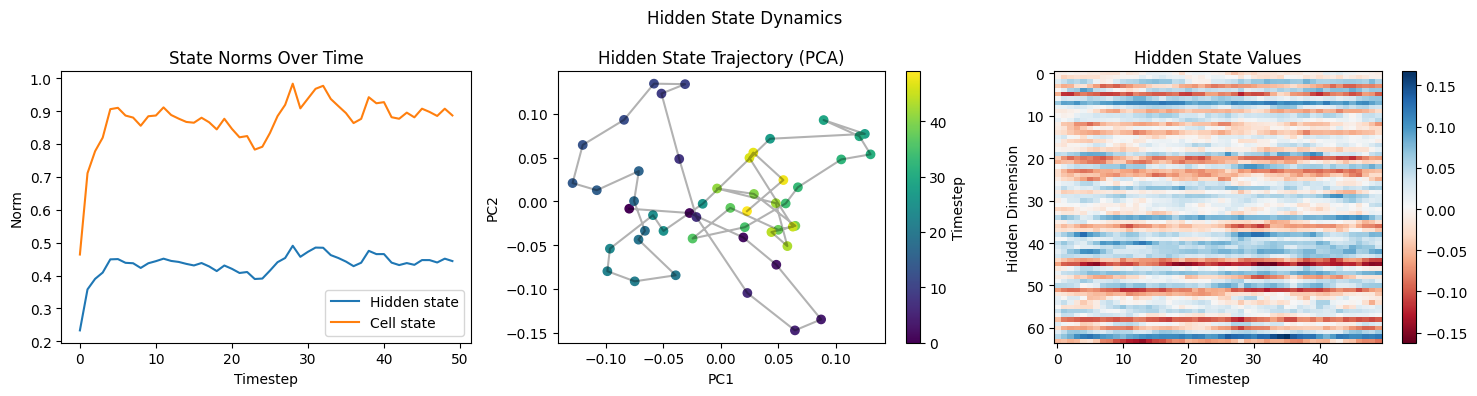

In [37]:
# Solution 2: Hidden state visualization

def visualize_hidden_dynamics(model, sequence: torch.Tensor, title: str = "Hidden State Dynamics"):
    model.eval()
    device = next(model.parameters()).device
    sequence = sequence.to(device)
    
    seq_len = sequence.shape[1]
    hidden_norms = []
    cell_norms = []
    hidden_states = []
    
    # Initialize hidden state
    h = torch.zeros(model.num_layers, 1, model.hidden_size, device=device)
    c = torch.zeros(model.num_layers, 1, model.hidden_size, device=device)
    
    with torch.no_grad():
        for t in range(seq_len):
            x_t = sequence[:, t:t+1, :]
            _, (h, c) = model.lstm(x_t, (h, c))
            
            hidden_norms.append(h[-1].norm().item())
            cell_norms.append(c[-1].norm().item())
            hidden_states.append(h[-1].squeeze().cpu().numpy())
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Plot norms
    axes[0].plot(hidden_norms, label='Hidden state')
    axes[0].plot(cell_norms, label='Cell state')
    axes[0].set_xlabel('Timestep')
    axes[0].set_ylabel('Norm')
    axes[0].set_title('State Norms Over Time')
    axes[0].legend()
    
    # PCA of hidden states
    from sklearn.decomposition import PCA
    hidden_array = np.array(hidden_states)
    if hidden_array.shape[0] > 2:
        pca = PCA(n_components=2)
        hidden_2d = pca.fit_transform(hidden_array)
        
        scatter = axes[1].scatter(hidden_2d[:, 0], hidden_2d[:, 1], 
                                  c=range(len(hidden_2d)), cmap='viridis')
        axes[1].plot(hidden_2d[:, 0], hidden_2d[:, 1], 'k-', alpha=0.3)
        plt.colorbar(scatter, ax=axes[1], label='Timestep')
        axes[1].set_xlabel('PC1')
        axes[1].set_ylabel('PC2')
        axes[1].set_title('Hidden State Trajectory (PCA)')
    
    # Hidden state heatmap
    im = axes[2].imshow(hidden_array.T, aspect='auto', cmap='RdBu')
    plt.colorbar(im, ax=axes[2])
    axes[2].set_xlabel('Timestep')
    axes[2].set_ylabel('Hidden Dimension')
    axes[2].set_title('Hidden State Values')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Test
class SimpleLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(32, 64, num_layers=2, batch_first=True)
        self.hidden_size = 64
        self.num_layers = 2

simple_lstm = SimpleLSTM()
test_seq = torch.randn(1, 50, 32)
visualize_hidden_dynamics(simple_lstm, test_seq)

In [38]:
# Solution 3: Peephole LSTM

class PeepholeLSTMCell(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Standard LSTM weights
        self.W_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size) / math.sqrt(input_size))
        self.W_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size) / math.sqrt(hidden_size))
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))
        
        # Peephole weights (diagonal matrices, stored as vectors)
        self.W_ci = nn.Parameter(torch.randn(hidden_size) * 0.1)  # Input gate peephole
        self.W_cf = nn.Parameter(torch.randn(hidden_size) * 0.1)  # Forget gate peephole
        self.W_co = nn.Parameter(torch.randn(hidden_size) * 0.1)  # Output gate peephole
        
        # Initialize forget gate bias
        with torch.no_grad():
            self.bias[hidden_size:2*hidden_size].fill_(1.0)
    
    def forward(self, x: torch.Tensor, state: Tuple[torch.Tensor, torch.Tensor]):
        h, c = state
        
        # Compute standard gates
        gates = F.linear(x, self.W_ih) + F.linear(h, self.W_hh) + self.bias
        i_gate, f_gate, g_gate, o_gate = gates.chunk(4, dim=1)
        
        # Add peephole connections for input and forget gates (using c_{t-1})
        i = torch.sigmoid(i_gate + self.W_ci * c)
        f = torch.sigmoid(f_gate + self.W_cf * c)
        g = torch.tanh(g_gate)
        
        # Update cell state
        c_new = f * c + i * g
        
        # Output gate peephole uses c_t (not c_{t-1})
        o = torch.sigmoid(o_gate + self.W_co * c_new)
        
        # Hidden state
        h_new = o * torch.tanh(c_new)
        
        return h_new, (h_new, c_new)


# Test
peephole_cell = PeepholeLSTMCell(32, 64)
x = torch.randn(4, 32)
h = torch.zeros(4, 64)
c = torch.zeros(4, 64)

h_new, (h_out, c_out) = peephole_cell(x, (h, c))
print(f"Peephole LSTM output shape: {h_new.shape}")
print(f"Cell state shape: {c_out.shape}")

Peephole LSTM output shape: torch.Size([4, 64])
Cell state shape: torch.Size([4, 64])


---

## Summary

### Key Takeaways

1. **RNN Basics**:
   - Process sequences by maintaining hidden state
   - Same weights applied at each timestep
   - Can be stacked (multi-layer) and bidirectional

2. **Vanishing Gradients**:
   - Gradients shrink exponentially with sequence length
   - Caused by repeated multiplication of weight matrix
   - Gradient clipping helps with exploding gradients

3. **LSTM**:
   - Cell state provides highway for gradient flow
   - Gates control information flow (forget, input, output)
   - Much better at learning long-term dependencies

4. **GRU**:
   - Simplified version with fewer parameters
   - Reset and update gates instead of LSTM's three gates
   - Often comparable performance to LSTM

5. **Practical Tips**:
   - Use packed sequences for variable-length inputs
   - Initialize forget gate bias to 1
   - Use gradient clipping (max_norm ≈ 1-5)
   - Consider bidirectional for classification tasks

### When to Use What

| Model | Use Case | Parameters |
|-------|----------|------------|
| Vanilla RNN | Short sequences, simple patterns | Fewest |
| LSTM | Long sequences, complex dependencies | Most |
| GRU | Good balance of performance/efficiency | Middle |